## Load vectors for time periods

In [1]:
import numpy as np
from gensim.models import KeyedVectors, Word2Vec
from copy import deepcopy

In [ ]:
vectors_root = '../5ysplits_models'

In [3]:
def load_vectors(vec_path):
    w2v = Word2Vec.load(vec_path)
    vectors = w2v.wv
    del w2v
    return vectors

In [12]:
base, target = 5, 4

In [ ]:
base_vecs = load_vectors(f"{vectors_root}/diachronic_wave_{base}_processed_model.bin")
target_vecs = load_vectors(f"{vectors_root}/diachronic_wave_{target}_processed_model.bin")

In [4]:
w1 = load_vectors(f"{vectors_root}/diachronic_wave_1_processed_model.bin")
w2 = load_vectors(f"{vectors_root}/diachronic_wave_2_processed_model.bin")
w3 = load_vectors(f"{vectors_root}/diachronic_wave_3_processed_model.bin")
w4 = load_vectors(f"{vectors_root}/diachronic_wave_4_processed_model.bin")
w5 = load_vectors(f"{vectors_root}/diachronic_wave_5_processed_model.bin")

In [5]:
waves = [w1, w2, w3, w4, w5]

In [6]:
w3.vectors.shape

(2583363, 300)

## Load Pauza

In [11]:
import json
from dataclasses import dataclass

In [ ]:
pauza_path = '../data/pauza_clean_tokens.jsonl'

In [ ]:
@dataclass
class PauzaInstance:
    text: str
    rating: str
    docid: str

    def aggregate_embeddings(self, model):
        aggregate = []
        for wpos_tuple in self.text:
            wp = '_'.join(wpos_tuple)
            try:
                vector = model[wp]
                aggregate.append(vector)
            except Exception as e:
                # print(e)
                # Skip since we're averaging anyway. Maybe add random uniform?
                pass

        if len(aggregate) == 0:
            print("Empty vectors")
            print(self.text)
            return None

        stacked_vectors = np.array(aggregate)
        mu = stacked_vectors.mean(0)

        return mu # Average across axis 0

In [ ]:
pauza = []
with open(pauza_path, 'r') as infile:
    for line in infile:
        instance = json.loads(line)
        pauza.append(PauzaInstance(**instance))

## Load Stone

In [12]:
stone_path = '../data/stone/stone_clean_tokens.jsonl'

In [14]:
@dataclass
class StoneInstance:
    text: str
    label: str
    docid: str

    def aggregate_embeddings(self, model):
        aggregate = []
        for wpos_tuple in self.text:
            wp = '_'.join(wpos_tuple)
            try:
                vector = model[wp]
                aggregate.append(vector)
            except Exception as e:
                # print(e)
                # Skip since we're averaging anyway. Maybe add random uniform?
                pass

        if len(aggregate) == 0:
            print("Empty vectors")
            print(self.text)
            return None

        stacked_vectors = np.array(aggregate)
        mu = stacked_vectors.mean(0)

        return mu # Average across axis 0

In [15]:
stone = []
with open(stone_path, 'r') as infile:
    for line in infile:
        instance = json.loads(line)
        stone.append(StoneInstance(**instance))

## Alignment

In [34]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.

    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # patch by Richard So [https://twitter.com/richardjeanso) (thanks!) to update this code for new version of gensim
    # base_embed.init_sims(replace=True)
    # other_embed.init_sims(replace=True)

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.get_normed_vectors()
    other_vecs = in_other_embed.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs)
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v)
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.vectors = (other_embed.vectors).dot(ortho)

    return other_embed

def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.index_to_key)
    vocab_m2 = set(m2.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.get_vecattr(w, "count") + m2.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.key_to_index[w] for w in common_vocab]
        old_arr = m.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.key_to_index = new_key_to_index
        m.index_to_key = new_index_to_key

        #print(len(m.key_to_index), len(m.vectors))

    return (m1,m2)

In [35]:
target_align_base = smart_procrustes_align_gensim(deepcopy(base_vecs), target_vecs)

NameError: name 'base_vecs' is not defined

## Create instances and train LinReg

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
clean_pauza = [instance for instance in pauza if instance.aggregate_embeddings(w5) is not None]

In [15]:
def do_eval(regressor, X_test, y_test):
    # Predict
    y_pred = regressor.predict(X_test)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    print(f"Test Mean Squared Error: {mse:.4f}")
    print(f"Test average score: {np.mean(y_pred):.2f}")

In [ ]:
# Average word vectors
X = clean_pauza
y = np.array([float(instance.rating) for instance in clean_pauza])

# Train/test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_base = [instance.aggregate_embeddings(w5) for instance in X_train_raw]

X_test_base = [instance.aggregate_embeddings(w5) for instance in X_test_raw]


# Create and train the regressor
regressor = LinearRegression()
regressor.fit(X_train_base, y_train)

# Predict
do_eval(regressor, X_test_base, y_test)

In [ ]:
X_test_target = [instance.aggregate_embeddings(target_align_base) for instance in X_test_raw]
print(np.allclose(X_test_base[0], X_test_target[0]))
do_eval(regressor, X_test_target, y_test)

## Train LogReg

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score

In [26]:
clean_stone = [instance for instance in stone if instance.aggregate_embeddings(w5) is not None]

In [27]:
def aggregate_emb(X_train, X_test, model):
    X_train_base = [instance.aggregate_embeddings(model) for instance in X_train]
    X_test_base = [instance.aggregate_embeddings(model) for instance in X_test]

    return X_train_base, X_test_base

def eval_clf(clf, X_test, y_test):
    # Predict
    y_pred = clf.predict(X_test)

    # Evaluate logreg
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Test F1 Score: {f1:.4f}")

    return y_pred

def train_clf(X_train_raw, X_test_raw, y_train, y_test, base_vecs):
    # Average word vectors
    X_train_base = [instance.aggregate_embeddings(base_vecs) for instance in X_train_raw]
    X_test_base = [instance.aggregate_embeddings(base_vecs) for instance in X_test_raw]

    # Create and train the classifier
    clf = LogisticRegression()
    clf.fit(X_train_base, y_train)

    # Predict
    eval_clf(clf, X_test_base, y_test)

    return clf

In [28]:
# Average word vectors
X = clean_stone
y = np.array([int(instance.label) for instance in clean_stone])

# Train/test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train clf
base_clf = train_clf(X_train_raw, X_test_raw, y_train, y_test, w5)

In [ ]:
from tqdm import tqdm
from sklearn.model_selection import KFold

X = clean_stone
y = np.array([int(instance.label) for instance in clean_stone])

kf = KFold(n_splits=30, shuffle=True, random_state=42)

clfs = []

for i, wave in enumerate(waves):
    print(f"Wave {i + 1}")
    clf_fold = []

    for train_index, test_index in kf.split(X):
        X_train_raw, X_test_raw = [X[i] for i in train_index], [X[i] for i in test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = train_clf(X_train_raw, X_test_raw, y_train, y_test, wave)
        clf_fold.append(clf)

    clfs.append(clf_fold)


In [ ]:
# Precompute alignments
aligned_waves = {}
for i in tqdm(range(len(waves))):
    for j in range(len(waves)):
        if i == j:
            continue
        aligned_waves[(i, j)] = smart_procrustes_align_gensim(deepcopy(waves[i]), deepcopy(waves[j]))


In [ ]:
matrices = []
for fold_idx in range(30):
    matrix = []
    for i, clf_list in enumerate(clfs):
        diff = []
        print(f"Base model  - Wave {i + 1}, Fold {fold_idx + 1}")
        clf = clf_list[fold_idx]  # Get classifier for current fold
        X_train_base, X_test_base = aggregate_emb(X_train_raw, X_test_raw, waves[i])
        y_base = eval_clf(clf, X_test_base, y_test)

        for j, wave in enumerate(waves):
            if i == j:
                diff.append(None)
                continue

            print(f"Target emb. - Wave {j + 1}")
            X_train_target, X_test_target = aggregate_emb(X_train_raw, X_test_raw, aligned_waves[(i, j)])
            y_target = eval_clf(clf, X_test_target, y_test)

            diff.append(np.round(np.mean((y_target - y_base)), 2))

        matrix.append(diff)
    matrices.append(matrix)

In [ ]:
matrices_array = np.array(matrices, dtype=float)
for i in range(matrices_array.shape[0]):
    for j in range(matrices_array.shape[1]):
        for k in range(matrices_array.shape[2]):
            if matrices_array[i, j, k] is None:
                matrices_array[i, j, k] = np.nan


In [ ]:
import scipy.stats as stats

# Calculate mean across all folds
np.nanmean(matrices_array, axis=0)
mean_matrix = np.mean(matrices_array, axis=0)

# Calculate p-values using one-sample t-test against mu=0
p_values = np.zeros_like(mean_matrix)
significance = np.full_like(mean_matrix, '', dtype=object)

for i in range(mean_matrix.shape[0]):
    for j in range(mean_matrix.shape[1]):
        if i != j:  # Skip diagonal
            t_stat, p_val = stats.ttest_1samp(matrices_array[:, i, j], 0)
            p_values[i, j] = p_val

            # Add significance stars
            if p_val < 0.01:
                significance[i, j] = '$^\ddagger$'
            elif p_val < 0.05:
                significance[i, j] = '$^\dagger$'
            # elif p_val < 0.05:
            #     significance[i, j] = '$\dagger$'

print("Mean values:")
print(mean_matrix)
print("\nSignificance levels:")
print(significance)


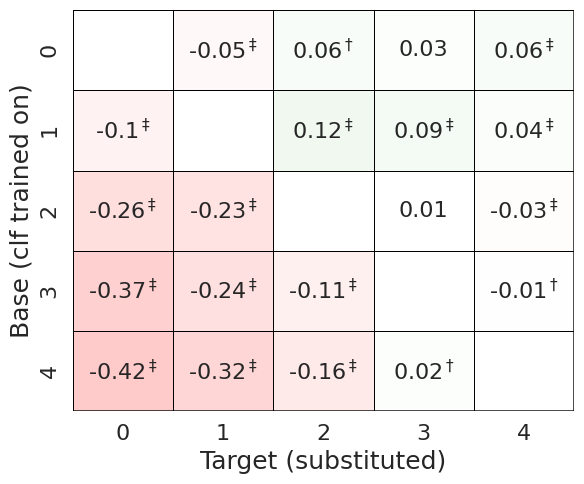

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Original matrix with None values
data = matrix

# Convert to NumPy array and mask None values
array = np.array(data, dtype=np.float32)
mask = np.isnan(array)
array = np.where(np.isnan(array), 0, array)

# Create custom red-to-green colormap
red_green_cmap = LinearSegmentedColormap.from_list("red_white_green", ["red", "white", "green"])

# Plotting with Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(array,
            cmap=red_green_cmap,
            vmin=-2, vmax=2,
            annot=np.where(~mask, array.astype(str) + significance, ''),
            fmt='',
            linewidths=0.5,
            linecolor='black',
            annot_kws={'size': 16})

plt.xlabel('Target (substituted)', fontsize=18)
plt.ylabel("Base (clf trained on)", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Add grid lines
plt.axvline(x=4.99, color='black', linewidth=0.5)
plt.axhline(y=4.99, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()


## Visualize results

In [ ]:
def load_drift_results(path, splits=5):
    a = np.zeros((splits, splits))
    with open(path, 'r') as infile:
        for idx, line in enumerate(infile):
            if idx == 0: continue # header
            parts = line.strip().split(",")
            base, target = int(parts[3]) - 1 , int(parts[4]) - 1
            # print(base, target)
            aps_base, aps_target = float(parts[7]), float(parts[9])
            a[base,target] = aps_target - aps_base # > 0 if sentiment increased
    return a

In [ ]:
data = load_drift_results('../output/semantic_drift_refilter.txt', splits=5)
print(data)

In [ ]:
type(data)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Example data
# data = np.random.uniform(-1, 1, (5, 5))

# Create a custom colormap: light red to white to light green
cmap = mcolors.LinearSegmentedColormap.from_list(
    'red_white_green', ['#ffcccc', '#ffffff', '#ccffcc'], N=256
)

# Plot
fig, ax = plt.subplots()
cax = ax.matshow(data, cmap=cmap)

# Write the numbers inside each square
for (i, j), val in np.ndenumerate(data):
    if i == j: continue
    ax.text(j, i, f'{val:.2f}', va='center', ha='center', fontsize=10)

# Hide axis ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Target (substituted)')
ax.set_ylabel('Base (clf trained on)')

# Optionally add a colorbar
fig.colorbar(cax)

plt.show()

In [27]:
np.set_printoptions(precision=2)
data_2y = load_drift_results('../output/semantic_drift_refilter_2y.txt', splits=12)
print(data_2y)
data_2y_clip = np.clip(data_2y, a_min=-4, a_max=4)

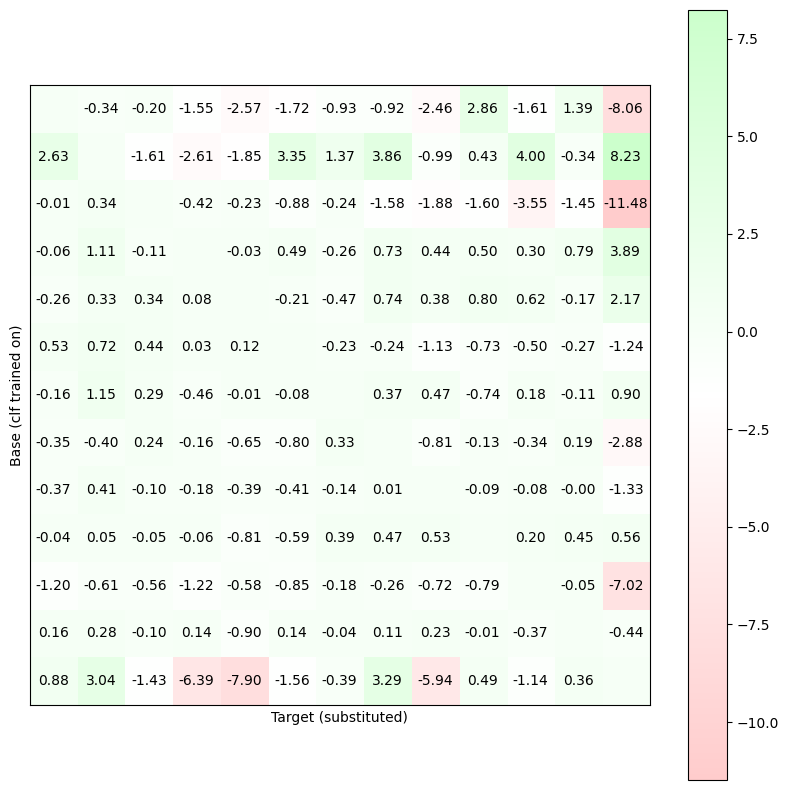

In [31]:
cmap = mcolors.LinearSegmentedColormap.from_list(
    'red_white_green', ['#ffcccc', '#ffffff', '#ccffcc'], N=256
)

# Compute row sums and column sums
row_sums = data_2y_clip.sum(axis=1, keepdims=True)  # shape (5, 1)
col_sums = data_2y_clip.sum(axis=0, keepdims=True)  # shape (1, 5)
total_sum = 0.

# Create extended 6x6 matrix
extended_data = np.block([
    [data_2y_clip, row_sums],
    [col_sums, total_sum]
])

# Plot
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(extended_data, cmap=cmap)

# Write the numbers inside each square
for (i, j), val in np.ndenumerate(extended_data):
    if i == j: continue
    ax.text(j, i, f'{val:.2f}', va='center', ha='center', fontsize=10)

# Hide axis ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Target (substituted)')
ax.set_ylabel('Base (clf trained on)')
ax.grid(which='minor', color='black', linewidth=0.5)
ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# Optionally add a colorbar
fig.colorbar(cax)

plt.show()